<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.855 · Modelos avanzados de minería de datos · PEC2</p>
<p style="margin: 0; text-align:right;">2021-1 · Máster universitario en Ciencia de datos (Data science)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática, Multimedia y Telecomunicación</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


# PEC 2: Métodos no supervisados

A lo largo de esta práctica veremos como aplicar distintas técnicas no supervisadas
así como algunas de sus aplicaciones reales:

 - **[Clustering con distintas estrategias](#ej1)**: k-means y regla del codo, basadas en densidad y jerárquicas.
 - **[Aplicación: generación de imágenes con reducción de dimensionalidad](#ej2)**. PCA y UMAP.
 - **[Aplicación: identificación de puntos de interés turísticos](#ej3)**.

---

Para ello vamos a necesitar las siguientes librerías:

In [57]:
import random

import umap
import numpy as np
import pandas as pd
import sklearn
from sklearn import cluster        # Algoritmos de clustering.
from sklearn import datasets       # Crear datasets.
from sklearn import decomposition  # Algoritmos de reduccion de dimensionalidad.

# Visualizacion.
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

<a id="ej1"></a>

## 1. Métodos de *clustering* (4 puntos)

Este ejercicio trata de explorar distintas técnicas de agrupamiento ajustándolas a distintos conjuntos de datos.

El objetivo es doble: entender la influencia de los parámetros en su comportamiento, y conocer sus limitaciones en la búsqueda de estructuras de datos.

### Generación de los conjuntos de datos

In [4]:
X_blobs, y_blobs = datasets.make_blobs(n_samples=1000, n_features=2, centers=4, cluster_std=1.6, random_state=42)
X_moons, y_moons = datasets.make_moons(n_samples=1000, noise=.07, random_state=42)
X_circles, y_circles = datasets.make_circles(n_samples=1000, factor=.5, noise=.05, random_state=42)

Cada dataset tiene 2 variables: una variable *X* que contiene 2 features (columnas) y tantas filas como muestras. Y una variable *y* que alberga las etiquetas que identifican cada cluster.

A lo largo del ejercicio no se usará la variable *y* (sólo con el objetivo de visualizar). El objetivo es a través de los distintos modelos de *clustering* conseguir encontrar las estructuras descritas por las variables *y*.

### 1 a. K-means

En este apartado se pide probar el algoritmo *k-means* sobre los tres datasets presentados anteriormente ajustando con los parámetros adecuados y analizar sus resultados.

In [5]:
X, y = X_blobs, y_blobs

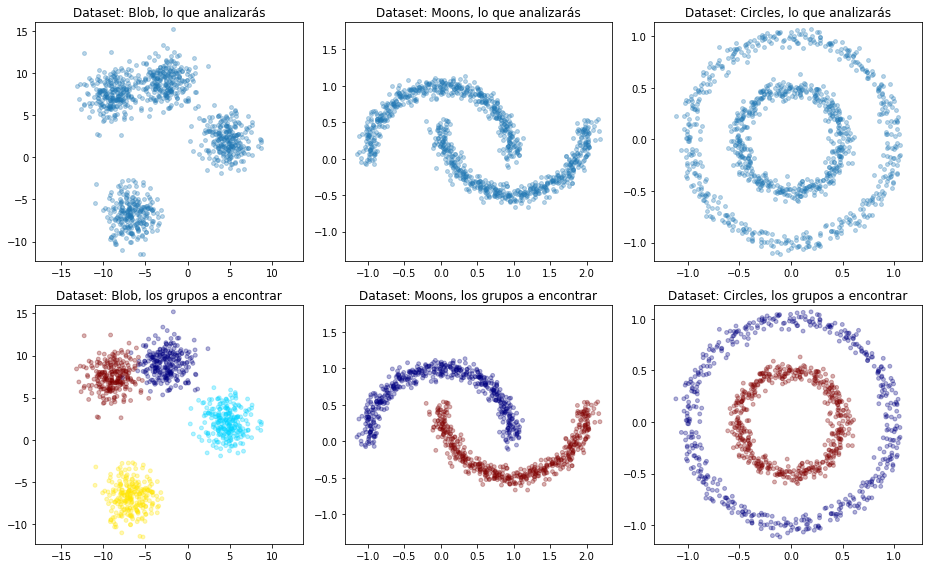

In [6]:
fig, axis = plt.subplots(2, 3, figsize=(13, 8))
for i, (X, y, ax, name) in enumerate(zip([X_blobs, X_moons, X_circles] * 2,
                                         [None] * 3 + [y_blobs, y_moons, y_circles],
                                         axis.reshape(-1),
                                         ['Blob', 'Moons', 'Circles'] * 2)):
    ax.set_title('Dataset: {}, '.format(name) + ('lo que analizarás' if i < 3 else 'los grupos a encontrar'))
    ax.scatter(X[:,0], X[:,1], s=15, c=y, alpha=.3, cmap='jet')
    ax.axis('equal')
plt.tight_layout()

Para estimar el número de clusters a detectar por *k-means*. Una técnica para estimar $k$ es, como se explica en la teoría:
> Los criterios anteriores (minimización de distancias intra grupo o maximización de distancias inter grupo) pueden usarse para establecer un valor adecuado para el parámetro k. Valores k para los que ya no se consiguen mejoras significativas en la homogeneidad interna de los segmentos o la heterogeneidad entre segmentos distintos, deberían descartarse.

Lo que popularmente se conocer como *regla del codo*.

Primero es necesario calcular la suma de los errores cuadráticos ([*SSE*](https://bl.ocks.org/rpgove/0060ff3b656618e9136b)) que consiste en la suma de todos los errores (distancia de cada punto a su centroide asignado) al cuadrado.

$$SSE = \sum_{i=1}^{K} \sum_{x \in C_i} euclidean(x, c_i)^2$$

Donde $K$ es el número de clusters a buscar por *k-means*, $x \in C_i$ son los puntos que pertenecen a i-ésimo cluster, $c_i$ es el centroide del cluster $C_i$ (al que pertenece el punto $x$), y $euclidean$ es la [distancia euclídea](https://en.wikipedia.org/wiki/Euclidean_distance).

Este procedimiento realizado para cada posible valor $k$, resulta en una función monótona decreciente, donde el eje $x$ representa los distintos valores de $k$, y el eje $y$ el $SSE$. Intuitivamente se podrá observar un significativo descenso del error, que indicará el valor idóneo de $k$.

**Se pide realizar la representación gráfica de la regla del codo junto a su interpretación, utilizando la librería ```matplotlib``` y la implementación en scikit-learn de [*k-means*](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html).**

<div class="alert alert-block alert-info">
    <strong>Implementación:</strong> cálculo y visualización de la regla del codo en el dataset Blobs.
</div>

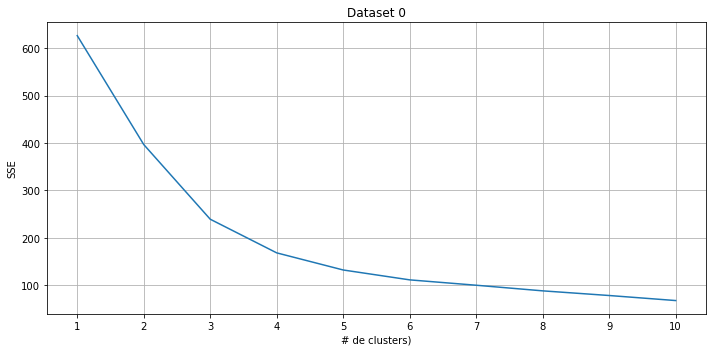

In [7]:
from sklearn.preprocessing import MinMaxScaler
from typing import List

def viz_regla_codo(ds: List[np.array], mink: int = 1, maxk: int = 10) -> None:
    fig, ax = plt.subplots(1, len(ds), figsize=(10, 5))
    for i, a in zip(range(len(ds)), ax if type(ax) == np.ndarray else (ax,)):
        x = range(mink, maxk + 1)
        y = []
        X = ds[i]
        
        for num_c in x:
            kmeans = cluster.KMeans(n_clusters=num_c)
            dists = kmeans.fit_transform(X)
            y.append(np.sum(np.min(dists, axis=1) ** 2))
            
        a.plot(x, y)
        a.set_xlabel('# de clusters)')
        a.set_ylabel('SSE')
        a.set_title('Dataset {}'.format(i))
        a.set_xticks(range(mink, maxk + 1))
        a.grid()
    plt.tight_layout()
    
    
plot_blob = viz_regla_codo([X])

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿Qué se interpreta en la gráfica? ¿Cómo podría mejorarse la elección de $k$?.  
</div>

### RESPUESTA: 

**_En el eje del # de clusters se observa que en $k=4$, el error se reduce significativamente. Por lo que una decisión razonable es pensar que el número de clusters originales es de 4._**

**_Se puede mejorar con una métrica que utilice la distancia inter grupo y no solo intra grupo_**

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> cálculo y visualización de los grupos en el dataset Blobs.
</div>

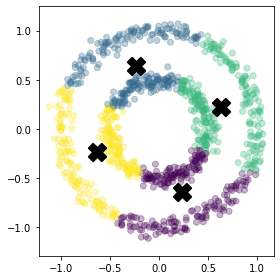

In [8]:
# Fuentes de las gráficas
# https://realpython.com/visualizing-python-plt-scatter/
# https://medium.com/@plog397/functions-to-plot-kmeans-hierarchical-and-dbscan-clustering-c4146ed69744
# https://datascience-enthusiast.com/Python/DBSCAN_Kmeans.html

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
kmeans = cluster.KMeans(n_clusters=4, algorithm='full')
ax.scatter(X[:,0], X[:,1], c=np.argmin(kmeans.fit_transform(X), axis=1), alpha=.3)
ax.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], s=300, c='k', marker='X', linewidths=2)
ax.axis('equal')
plt.tight_layout()

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿Qué ha sucedido? Explica los motivos por los que crees que se ha producido ese resultado.  
</div>

### RESPUESTA:

**_Usando k-means con distancia euclídea asumimos que los clusters son n-esferas. En la práctica podemos verlo como diagramas de Voronoi en base a lo que se observa en los resultados anteriores._**

In [9]:
X, y = X_moons, y_moons

<div class="alert alert-block alert-info">
    <strong>Implementación:</strong> cálculo y visualización de la regla del codo en el dataset Moons.
</div>

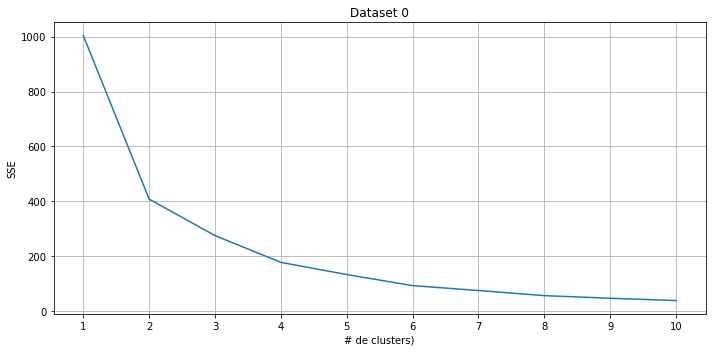

In [10]:
plot_moon = viz_regla_codo([X])

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿Qué se interpreta en la gráfica? ¿Cómo podría mejorarse la elección de $k$?.  
</div>

### RESPUESTA:

**_En este caso se comienza a ver un decrecimiento en $k=2$, por lo que se podría asumir que es el número de clusters. Sin embargo, no está claramente definido como en el caso del dataset de blobs. Se podría mejorar cambiando de métodos de clustering, usando otros criterios de distancia entre las observaciones del dataset._**

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> cálculo y visualización de los grupos en el dataset Moons.
</div>

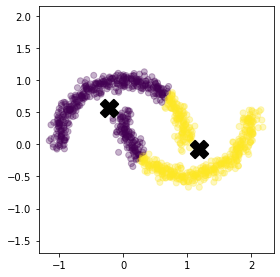

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
kmeans = cluster.KMeans(n_clusters=2, algorithm='full')
ax.scatter(X[:,0], X[:,1], c=np.argmin(kmeans.fit_transform(X), axis=1), alpha=.3)
ax.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], s=300, c='k', marker='X', linewidths=2)
ax.axis('equal')
plt.tight_layout()

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿Qué ha sucedido? Explica los motivos por los que crees que se ha producido ese resultado.  
</div>

### RESPUESTA:

**_Usando k-means con distancia euclídea asumimos que los clusters son nubes de puntos. En la práctica podemos verlo como semícirculos entrelazados, que es lo que se observa en los resultados anteriores_**

**_Es normal que no se produzcan los resultados esperados porque los clusters tienen distintas formas y no se ajustan a nubes de puntos, conocidos como diagramas de Voronoi._**

In [12]:
X, y = X_circles, y_circles

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> cálculo y visualización de la regla del codo en el dataset Circles.
</div>

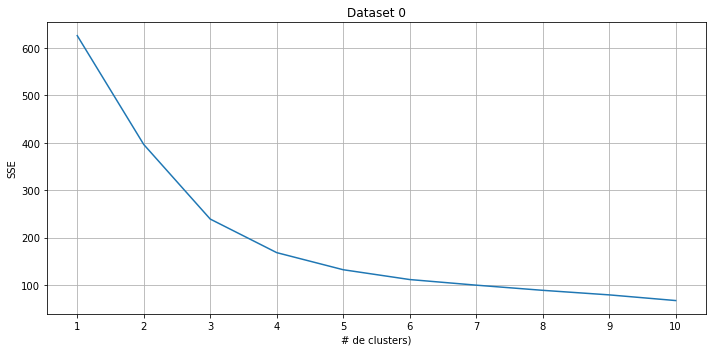

In [13]:
plot_circle = viz_regla_codo([X])

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿Qué se interpreta en la gráfica? ¿Cómo podría mejorarse la elección de $k$?.  
</div>

### RESPUESTA:

_**En este caso no es tan fácil distinguir un $k$ adeucado, ya que aplicando la regla del codo podemos concluir que $k=4$. Este valor no coincide con los dos clusters esperados**_

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> cálculo y visualización de los grupos en el dataset Circles.
</div>

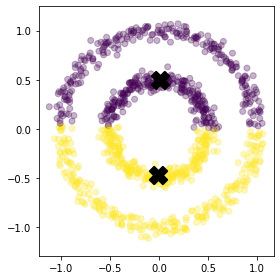

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
kmeans = cluster.KMeans(n_clusters=2, algorithm='full')
ax.scatter(X[:,0], X[:,1], c=np.argmin(kmeans.fit_transform(X), axis=1), alpha=.3)
ax.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], s=300, c='k', marker='X', linewidths=2)
ax.axis('equal')
plt.tight_layout()

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿Qué ha sucedido? Explica los motivos por los que crees que se ha producido ese resultado.  
</div>

### RESPUESTA: 

**_Usando k-means con distancia euclídea asumimos que los clusters son nubes de puntos. En la práctica podemos verlo como 2 circulos concentricos, que es lo que se observa en los resultados anteriores. Además no se corresponde con el valor de $k=4$ definido, aplicando la regla del codo._**

**_Es normal que no se produzcan los resultados esperados porque los clusters tienen distintas formas y no se ajustan a nubes de puntos, conocidos como diagramas de Voronoi._**

### 1 b. Algoritmos basados en densidad: DBScan

En este apartado se pide aplicar clustering por densidad como [DBSCAN](https://en.wikipedia.org/wiki/DBSCAN) a los datasets anteriores para detectar los grupos subyacentes.

In [15]:
X, y = X_blobs, y_blobs

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> prueba la implementación de <a href="http://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html">DBSCAN en scikit-learn</a> jugando con los parámetros <i>eps</i> y <i>min_samples</i> para encontrar los grupos (y <i>outliers</i>) del dataset Blobs.
</div>

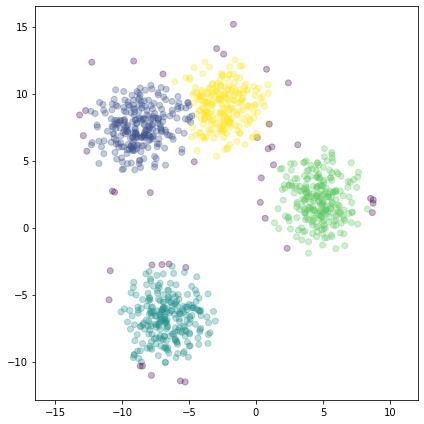

In [16]:
model_plot = cluster.DBSCAN(eps=2.15, min_samples=100, n_jobs=-1)
clusters = model_plot.fit(X)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.scatter(X[:,0], X[:,1], c=clusters.labels_, alpha=.3)
ax.axis('equal')
plt.tight_layout()

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿Qué ha sucedido? Explica los motivos por los que crees que se ha producido ese resultado.  
</div>

### RESPUESTA: 

**_Aplicando el algoritmo DBSCAN con un epsilon (eps) de 2.15 se consigue encontrar los cuatro clusters ($k=4$) que se definió previamente aplicando la regla del codo. Al intentar con varios valores se nota que tiene mucha densidad en el centro y están separados. La densidad de puntos permite distinguir los grupos de puntos u observaciones_**

**_Además se puede apreciar los outliers en los alrededores de cada cluster (nube de puntos)_**

In [17]:
X, y = X_moons, y_moons

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> prueba la implementación de DBScan jugando con los parámetros <i>eps</i> y <i>min_samples</i> para encontrar los grupos (y <i>outliers</i>) del dataset Moons.
</div>

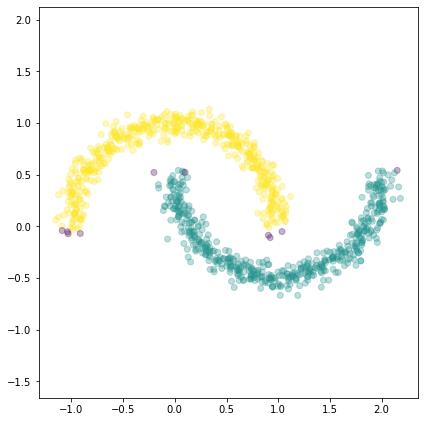

In [18]:
model = cluster.DBSCAN(eps=0.20, min_samples=50, n_jobs=-1)
clusters = model.fit(X)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.scatter(X[:,0], X[:,1], c=clusters.labels_, alpha=.3)
ax.axis('equal')
plt.tight_layout()

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿Qué ha sucedido? Explica los motivos por los que crees que se ha producido ese resultado.  
</div>

### RESPUESTA:

**_Usando DBSCAN con un valor epsilon de 0.20 se consigue encontrar ambos clusters porque ambas lunas tienen una densidad constante a lo largo de cada uno de ellas y están suficientemente separadas. Eso hace que al guiarse por la densidad de puntos se puedan distinguir ambas estructuras_**

**_También se pueden detectar un cuantos valores outliers en ambos clusters_**

In [19]:
X, y = X_circles, y_circles

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> prueba la implementación de DBScan jugando con los parámetros <i>eps</i> y <i>min_samples</i> para encontrar los grupos (y <i>outliers</i>) del dataset Circles.
</div>

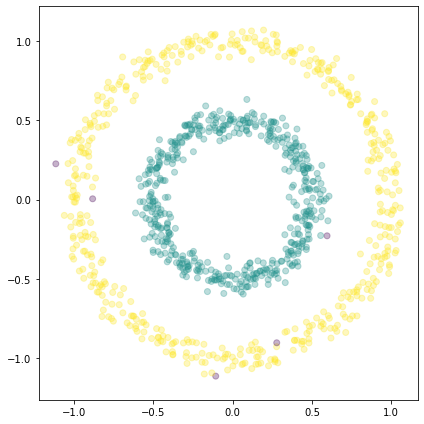

In [20]:
model = cluster.DBSCAN(eps=0.1, min_samples=10, n_jobs=-1)
clusters = model.fit(X)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.scatter(X[:,0], X[:,1], c=clusters.labels_, alpha=.3)
ax.axis('equal')
plt.tight_layout()

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿Qué ha sucedido? Explica los motivos por los que crees que se ha producido ese resultado.  
</div>

### RESPUESTA:

**_Usando DBSCAN con un valor epsilon de 0.10 se consigue encontrar ambos clusters porque ambos circulos tienen una densidad constante a lo largo de cada uno de ellos y están suficientemente separados_**

**_Es oportuno recordar que DBSCAN es preciso para datos que contienen clusters de densidad similar. También se pueden detectar un cuantos valores outliers en ambos grupos_**

### 1 c. Algoritmos jerárquicos

En este apartado se pide visualizar mediante un [dendrograma](https://en.wikipedia.org/wiki/Dendrogram) la construcción progresiva de los grupos mediante un algoritmo jerárquico aglomerativo (estrategia *bottom-up*). Con ello se pretende encontrar un método gráfico para entender el comportamiento del algoritmo y encontrar los *clusters* deseados en cada dataset.

In [98]:
X, y = X_blobs, y_blobs

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> prueba la implementación de <a href="https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html">clustering jerárquico de scipy</a> probando distintos <a href="https://en.wikipedia.org/wiki/Hierarchical_clustering#Linkage_criteria">criterios de enlace o <i>linkage</i></a> permitiendo identificar los clusters subyacentes (mostrando su resultado) y su dendrograma para el dataset Blobs.<br>
Puedes importar las librerías necesarias para ello.
</div>

In [121]:
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import dendrogram, linkage as link, fcluster as fclus

# Definimos una función que me permita graficar los distintos criterios de enlace que se aplican a cada dataset
def viz_linkage(enlace, data, distance_threshold):
    fig, ax = plt.subplots(1, 2, figsize=(15, 8))
    linkage = link(pdist(data), enlace)
    dendrogram(linkage, ax=ax[0])
    ax[0].set_title('Dataset {} con linkage "{}"'.format(data, enlace))
    cluster_idx = fclus(linkage, t=distance_threshold, criterion='distance')
    ax[1].scatter(data[:, 0], data[:, 1], c=cluster_idx, alpha=.3)
    ax[1].axis('equal')
    plt.tight_layout()

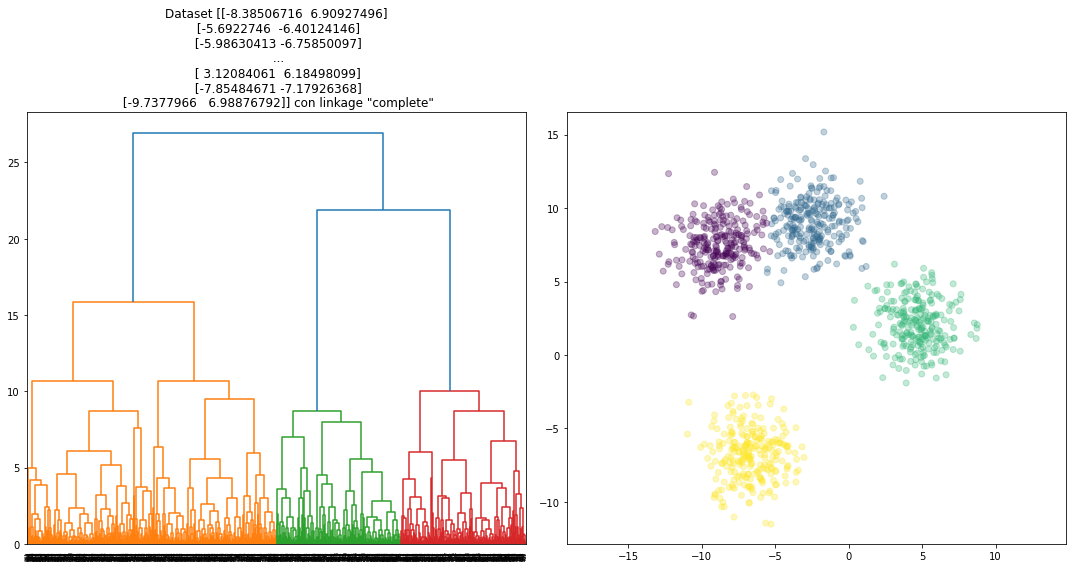

In [114]:
# Usamos la función definida previamente con los parámetros: criterio de enlace, data y el umbral de distancia
viz_linkage('complete', X, 15)

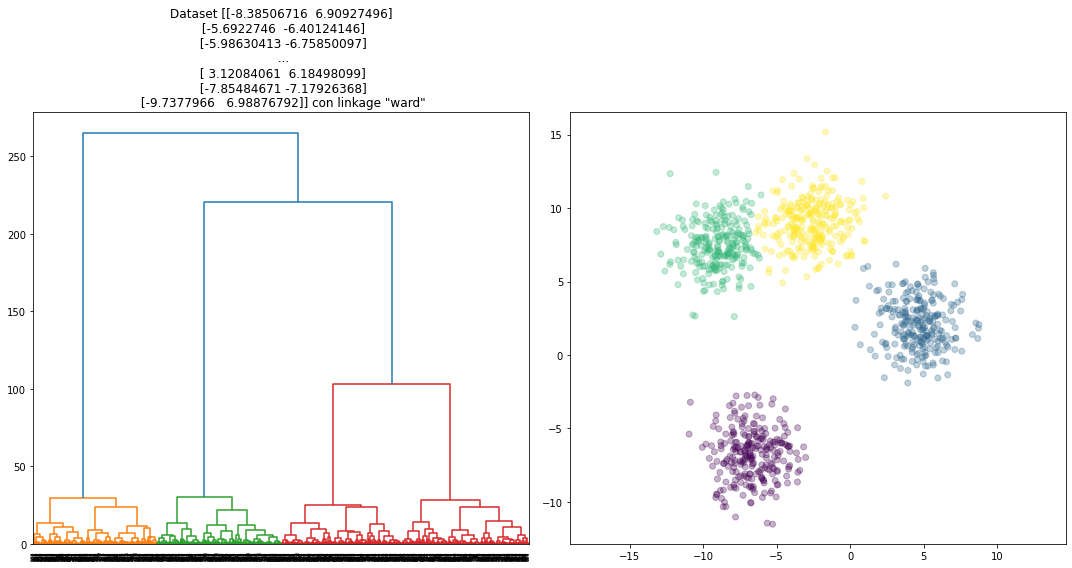

In [118]:
# Usamos la función definida previamente con los parámetros: criterio de enlace, data y el umbral de distancia
viz_linkage('ward', X, 50)

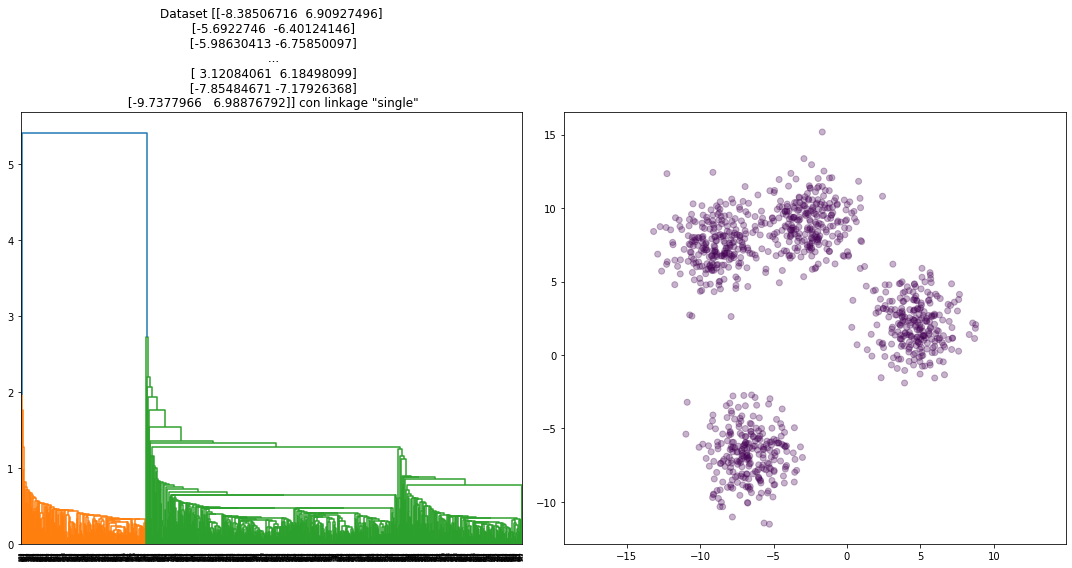

In [117]:
# Usamos la función definida previamente con los parámetros: criterio de enlace, data y el umbral de distancia
viz_linkage('single', X, 15)

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> Interpreta el dendrograma y comenta qué criterio de enlace se ha comportado mejor. ¿Por qué?
</div>

### RESPUESTA:

_Los criterios de enlaces (linkage) **complete** y **ward** ha permitido definir correctamente los clusters contenidos en este dataset_

_El enlace **single** no lo consigue ya que hay 2 nubes cercanas._

In [119]:
X, y = X_moons, y_moons

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>
prueba la implementación de <a href="https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html">clustering jerárquico de scipy</a> probando distintos <a href="https://en.wikipedia.org/wiki/Hierarchical_clustering#Linkage_criteria">criterios de enlace o <i>linkage</i></a> permitiendo identificar los clusters subyacentes (mostrando su resultado) y su dendrograma para el dataset Moons.<br>
Puedes importar las librerías necesarias para ello.
</div>

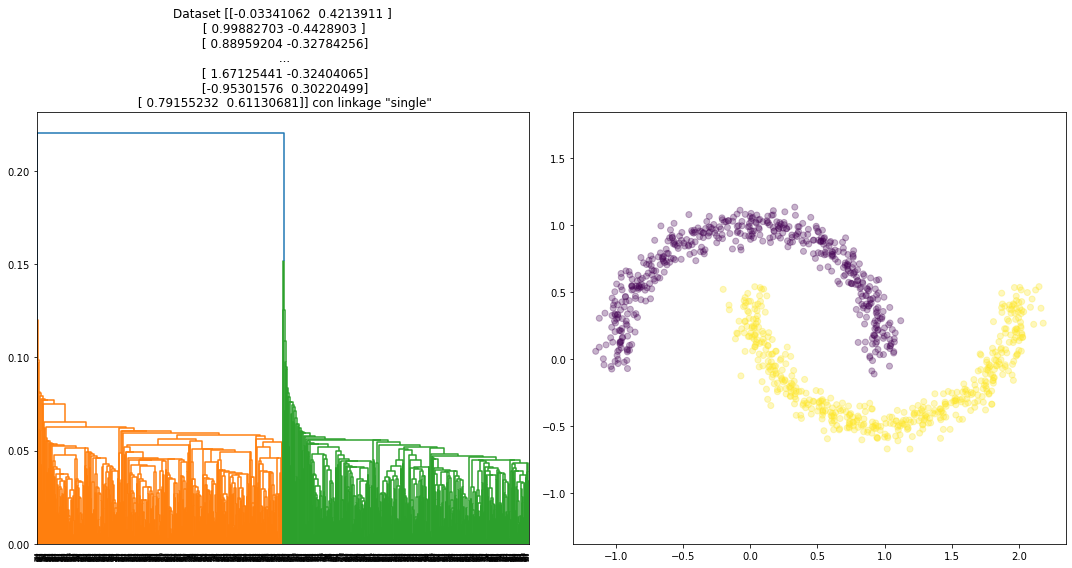

In [120]:
viz_linkage('single', X, 0.2)

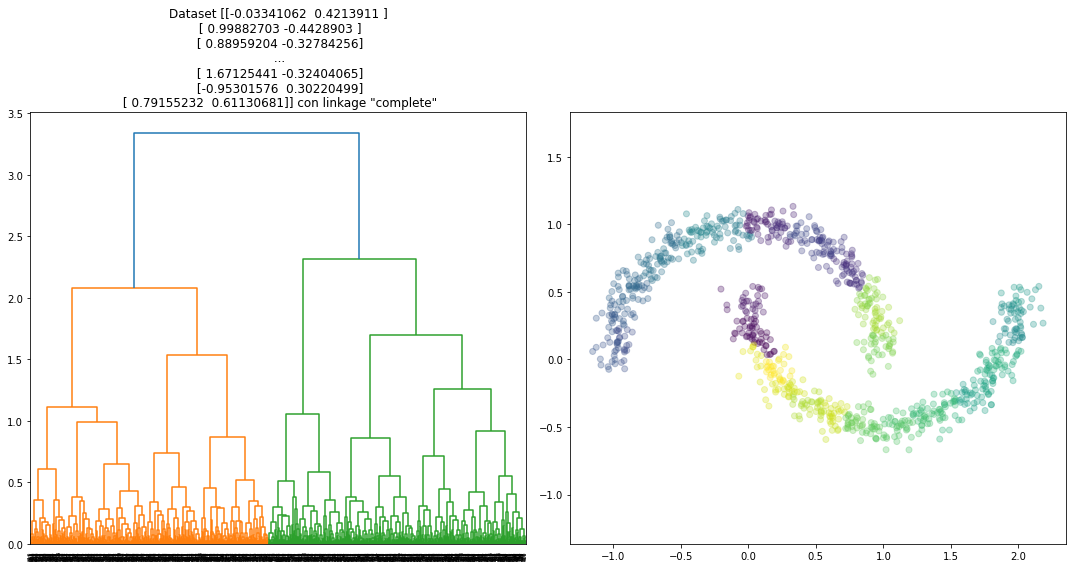

In [122]:
viz_linkage('complete', X, 0.2)

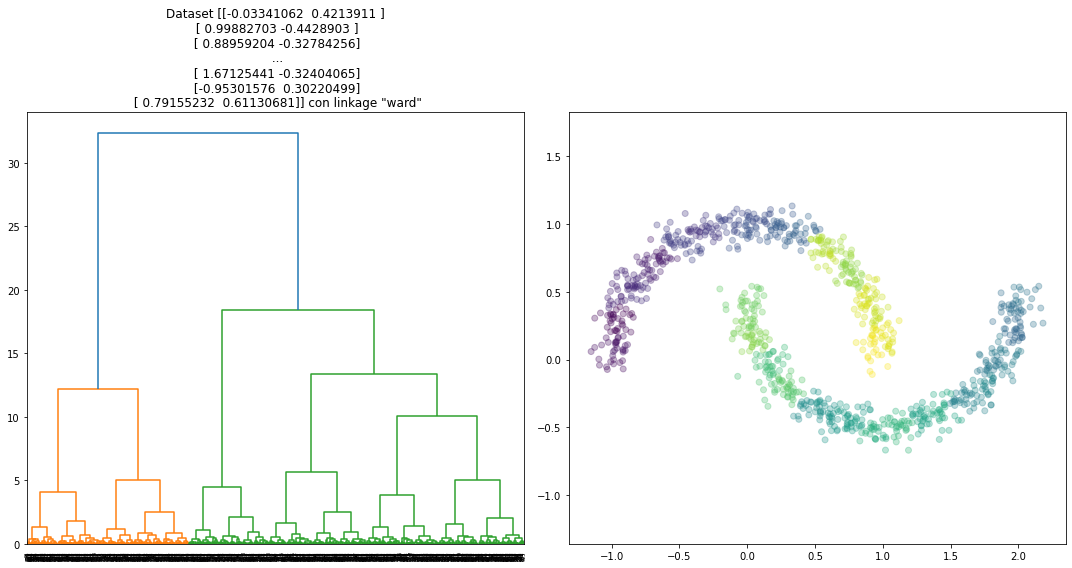

In [123]:
viz_linkage('ward', X, 0.2)

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> Interpreta el dendrograma y comenta qué criterio de enlace se ha comportado mejor. ¿Por qué?
</div>

### RESPUESTA:

**_El enlace $single$ es el que, para este dataset, permite distinguir mejor los clusters esperados_**

**_El enlace simple, definido como la mínima distancia entre elementos de cada cluster:_**

$$\min\{\,d(a, b):a\in A,\,b\in B\,\}$$

**_Donde $a$ e $b$ son elementos de distintos clusters ($A$ y $B$). Este criterio de enlace (linkage) es ir formando los clusters mediante sus puntos que se encuentran más próximos. Así, se van dibujando las formas de los clusters, permitiendo encontrar formas complejas bien separadas entre ellas._**

**_No se consigue el mismo resultado con los criterios $ward$ y $complete$_**

In [124]:
X, y = X_circles, y_circles

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>
prueba la implementación de <a href="https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html">clustering jerárquico de scipy</a> probando distintos <a href="https://en.wikipedia.org/wiki/Hierarchical_clustering#Linkage_criteria">criterios de enlace o <i>linkage</i></a> permitiendo identificar los clusters subyacentes (mostrando su resultado) y su dendrograma para el dataset Circles.<br>
Puedes importar las librerías necesarias para ello.
</div>

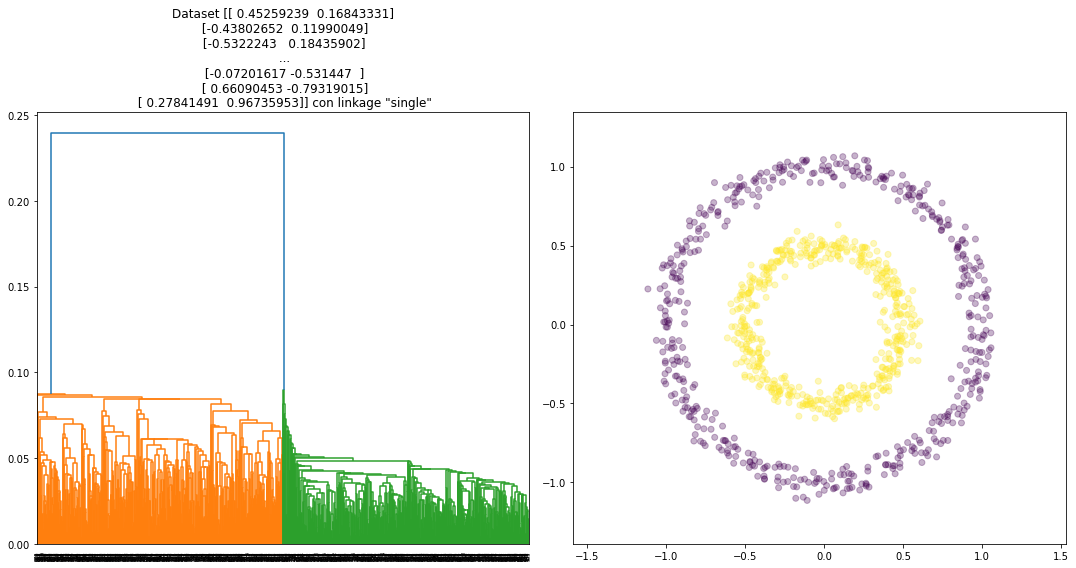

In [125]:
viz_linkage('single', X, 0.2)

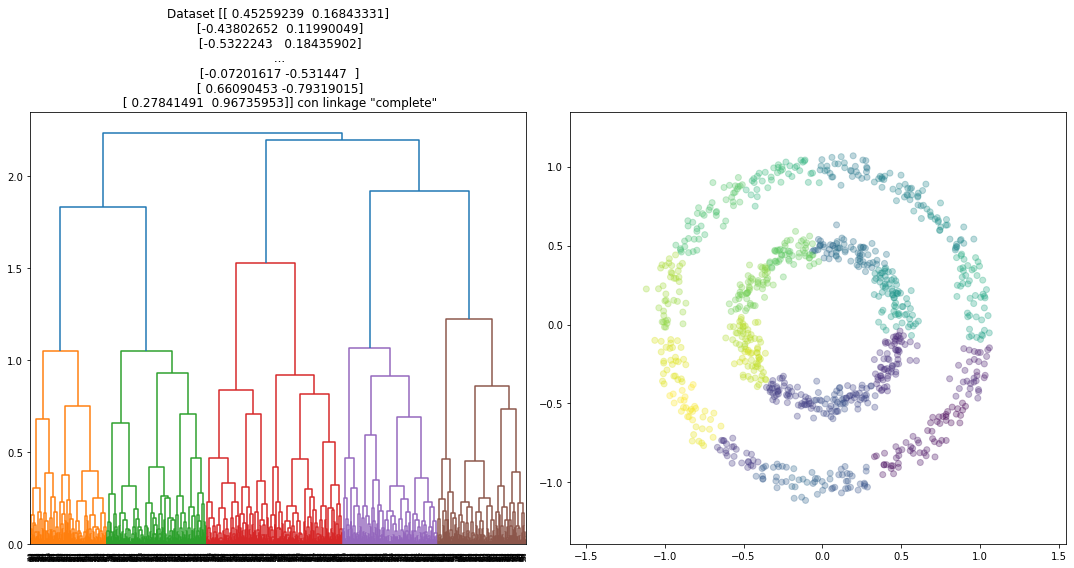

In [126]:
viz_linkage('complete', X, 0.2)

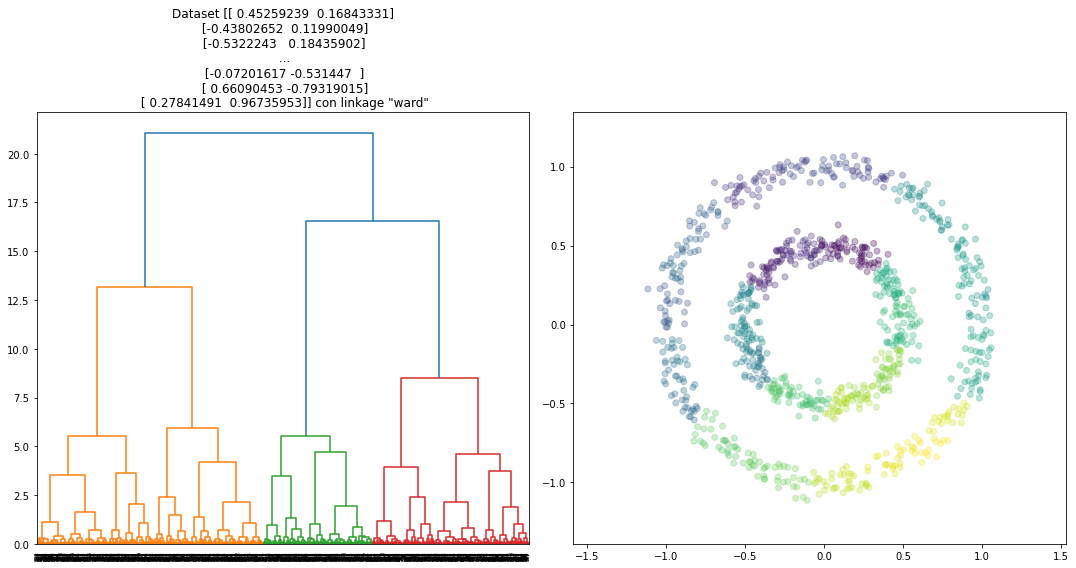

In [127]:
viz_linkage('ward', X, 0.2)

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> Interpreta el dendrograma y comenta qué criterio de enlace se ha comportado mejor. ¿Por qué?
</div>

### RESPUESTA:

**_El enlace $single$ es el que, para este dataset, permite distinguir mejor los clusters esperados_**

**_El enlace simple, definido como la mínima distancia entre elementos de cada cluster:_**

$$\min\{\,d(a, b):a\in A,\,b\in B\,\}$$

**_Donde $a$ e $b$ son elementos de distintos clusters ($A$ y $B$). Este criterio de enlace (linkage) es ir formando los clusters mediante sus puntos que se encuentran más próximos. Así, se van dibujando las formas de los clusters, permitiendo encontrar formas complejas bien separadas entre ellas._**

**_No se consigue el mismo resultado con los criterios $ward$ y $complete$_**

<a id="ej2"></a>

## 2. Aplicación: generación de imágenes con reducción de dimensionalidad (3 puntos)

Es posible aplicar una amplia variedad de algoritmos para la reducción de dimensionalidad. Para ello se empleará el dataset MNIST compuesto de miles de dígitos manuscritos del 0 al 9. Donde cada imagen se compone de 784 píxeles (imágenes de 28 x 28), por lo que se parte de un número alto de dimensiones.

In [61]:
X, y = sklearn.datasets.fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)

Por lo que cada muestra (las 70k filas del dataset) se componen de 784 dimensiones:

In [29]:
X.shape

(70000, 784)

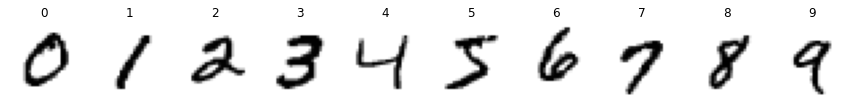

In [30]:
fig, axis = plt.subplots(1, 10, figsize=(12, 6))
for i, ax in enumerate(axis):
    ax.imshow(X[y == str(i)][0].reshape(28, 28), cmap='gray_r')
    ax.set_title(str(i))
    ax.axis('off')
plt.tight_layout()

Si cada algoritmo obtiene resultados distintos a la hora de reducir la dimensionalidad, ¿qué representación es más fiel a la distribución original?

Antes de reducir las 784 dimensiones originales de cada muestra a 2 para poder visualizarlas en 2 dimensiones, es muy útil conocer, o al menos intuir, la estructura en alta dimensionalidad de los datos.

Para ello se puede hacer uso del dendrograma como heurística para conocer la disposición original de los datos y comprobar si la proyección es similar a lo mostrado por el dendrograma.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> aprender una proyección a 2 dimensiones de las muestras de X con <a href="https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html">PCA</a> y proyectar el conjunto X a dos dimensiones. Después visualizarlo en un scatter plot.

Utiliza las etiquetas de y (el número manuscrito al que se corresponde cada muestra), en el parámetro label (en la llamada a scatter) y la función legend en la visualización para saber la clase correspondiente a cada punto e interpretar el resultado de la reducción de dimensionalidad y poder interpretar el resultado de la proyección.
</div>

Varianza explicada: [0.09746116 0.07155445]
Varianza acumulada: 0.1690156049192555


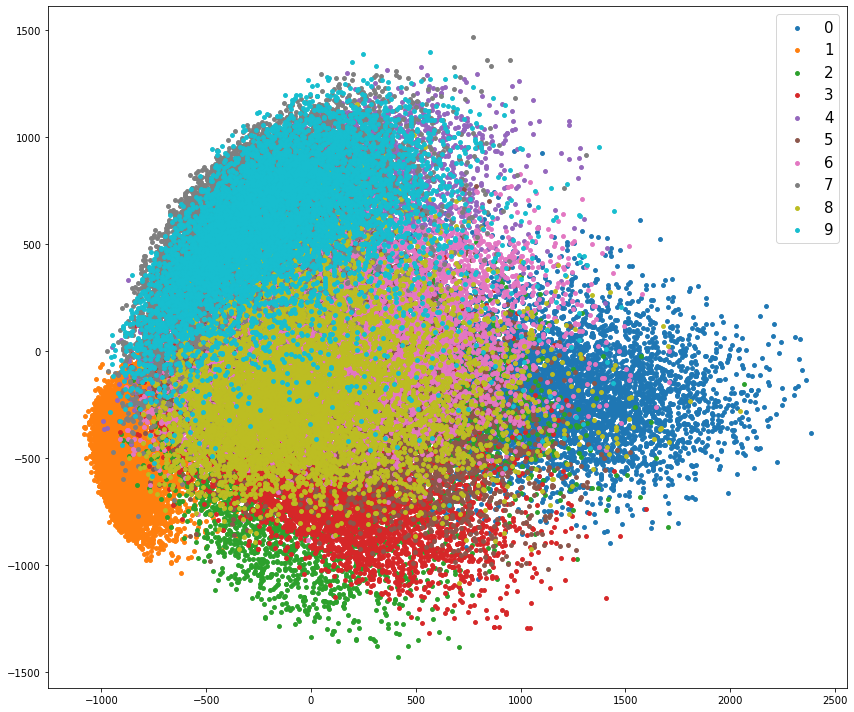

In [31]:
model_mnist = decomposition.PCA(n_components=2)
X_pca = model_mnist.fit_transform(X)

print("Varianza explicada:", model_mnist.explained_variance_ratio_)
print("Varianza acumulada:", sum(model_mnist.explained_variance_ratio_))

fig, ax = plt.subplots(1, 1, figsize=(12, 10))
for i in range(10):
    ax.scatter(X_pca[y == str(i),0], X_pca[y == str(i),1], s=15, label=str(i))
plt.legend(fontsize=15)
plt.tight_layout()


<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿Qué puedes interpretar de la proyección? ¿Las clases han quedado visiblemente separadas? ¿Por qué?
</div>

### **RESPUESTA:** 

**_En la proyección las clases correspondientes a los números 0, 1, 2, 3, 8 y 9 están definidas correctamente. También vemos que los números 4, 5 y 6 están muy dispersos. La nube de puntos de los números 9 y 7 se solapan casi totalmente._**

**_Esto sucede porque el método PCA realiza una transformación al dataset original, donde el resultado me presenta una perspectiva de la totalidad de los datos. Esto permite apreciar como se ubican las clases desde un ángulo en particular. Sería una buena opción visualizar en la proyección únicamente las clases de los número de 2 en 2_**

**_También es importante recordar que al aplicar el PCA para reducir a 2 dimensiones hemos obtenido una varianza acumulada de 17%, lo cual es demasiada baja. Esto quiere decir que solo ese porcentaje de representatividad tiene del dataset original_**

En la gráfica anterior cada punto representa una muestra en 2 dimensiones. Con PCA es posible <a href="https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA.inverse_transform">invertir la transformación</a> para que, a partir de cada punto 2d, se obtenga de nuevo (aproximadamente) la imagen original (784 dimensiones).

Por lo que es posible "generar" nuevas imágenes eligiendo puntos aleatoriamente del plano 2d, y pedirle al modelo PCA aprendido que invierta la transformación para obtener las "teóricas" imágenes que habrían sido proyectadas a esos puntos del espacio proyectado.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> calcular el máximo y mínimo de cada una de las dos dimensiones y, para cada una de ellas, <a href="https://numpy.org/doc/stable/reference/generated/numpy.linspace.html">generar una secuencia</a> de 10 valores con igual separación.
</div>

In [37]:
# Dimensiones de los componentes obtenidos con PCA
X_pc1 = X_pca[:, 0]
X_pc2 = X_pca[:, 1]

# Mínimo y máximo del PC1
Xpc1_max = X_pc1.max()
Xpc1_min = X_pc1.min()

print("Min-Max PC1: [{}, {}]".format(Xpc1_min, Xpc1_max))

# Mínimo y máximo del PC2
Xpc2_max = X_pc2.max()
Xpc2_min = X_pc2.min()

print("Min-Max PC2: [{}, {}]".format(Xpc2_min, Xpc2_max))
print("")

# Secuencias PC1 y PC2
PA1_values = np.linspace(Xpc1_min, Xpc1_max, 10)
PA2_values = np.linspace(Xpc2_min, Xpc2_max, 10)

print("Secuencia PA1: {}".format(PA1_values))
print("Secuencia PA2: {}".format(PA2_values))

Min-Max PC1: [-1081.1451673760557, 2383.9843421561986]
Min-Max PC2: [-1428.8489199082626, 1464.423316282626]

Secuencia PA1: [-1081.14516738  -696.13077743  -311.11638748    73.89800247
   458.91239242   843.92678236  1228.94117231  1613.95556226
  1998.96995221  2383.98434216]
Secuencia PA2: [-1428.84891991 -1107.374227    -785.89953409  -464.42484118
  -142.95014827   178.52454464   499.99923755   821.47393046
  1142.94862337  1464.42331628]


Con las dos secuencias de 10 (una por cada dimensión del plano de proyección) valores es posible combinar los puntos de ambas secuencias para generar 100 combinaciones (puntos 2d) que teselan el plano sobre el que PCA ha proyectado las muestras.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> invertir la transformación para cada uno de los 100 puntos y visualizar su imagen asociada en una matriz de 10 x 10 imágenes (tratando de preservar su posición en el espacio proyectado).
</div>

In [44]:
combinaciones = np.array([
    [x, y]
    for x in PA1_values
    for y in PA2_values
])

inv_transformed_points = model_mnist.inverse_transform(combinaciones)

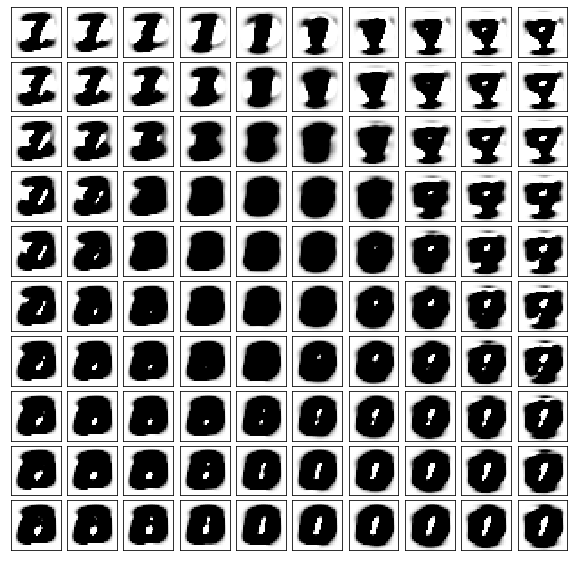

In [46]:
# Función adoptada desde https://www.kaggle.com/parulpandey/part1-visualizing-kannada-mnist-with-pca

def plot_digits(data):
    fig, axes = plt.subplots(10, 10, figsize=(10, 10),
                             subplot_kw={'xticks':[], 'yticks':[]},
                             gridspec_kw=dict(hspace=0.1, wspace=0.1))
    for i, ax in enumerate(axes.flat):
        ax.imshow(data[i].reshape(28, 28),
                  cmap='binary', interpolation='nearest',
                  clim=(0, 16))
        
plot_digits(inv_transformed_points)

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿Qué puedes interpretar de las imágenes reconstruidas / interpoladas? ¿Genera números o transiciones entre números visualmente creíbles? ¿Por qué?
</div>

### RESPUESTA: 

**_No se puede visualizar correctamente las imágenes reconstruidas. Es necesario recordar que PCA busca proyectar los datos originales en un hiperplano mientras_**

**_Ahora es necesario recordar que en el caso del dataset analizado previamente, una vez aplicado el PCA, se obtuvo una representatividad total de 17%  (a través de varianza acumulada) entre los 2 componente que arrojó la reducción de dimensionalidad. Este valor es demasiado bajo para esperar que los números sean visualmente creíbles._**

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿Podría haberse conseguido lo mismo con <a href="https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html">t-SNE</a>? ¿Por qué?
</div>

### RESPUESTA:

Considerando: 

_"(t-SNE) takes a high dimensional data set and reduces it to a low dimensional graph that retains a lot of the original information. It does so by giving each data point a location in a two or three-dimensional map. This technique finds clusters in data thereby making sure that an embedding preserves the meaning in the data. t-SNE reduces dimensionality while trying to keep similar instances close and dissimilar instances apart."_ [Fuente](https://towardsdatascience.com/dimensionality-reduction-for-data-visualization-pca-vs-tsne-vs-umap-be4aa7b1cb29)

Y también:

_"It is highly recommended to use another dimensionality reduction method (e.g. PCA for dense data or TruncatedSVD for sparse data) to reduce the number of dimensions to a reasonable amount (e.g. 50) if the number of features is very high."_ [Fuente](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)

**Se puede inferir que se hubiera conseguido un mejor resultado, ya que la técnica t-SNE está optimizada para datasets de alta dimensionalidad, como es el caso (MNIST) estudiado, que contiene imagenes. Además se debe mencionar que, computacionalmente la aplicación de este método es más costosa.**

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> aprender una proyección a 2 dimensiones de las muestras de X con <a href="https://towardsdatascience.com/how-exactly-umap-works-13e3040e1668">UMAP</a> (con los parámetros por defecto) usando la librería <a href="https://umap-learn.readthedocs.io/en/latest/">umap-learn</a> y proyectar el conjunto X a dos dimensiones. Después visualizarlo en un scatter plot.

Utiliza las etiquetas de y (el número manuscrito al que se corresponde cada muestra), en el parámetro label (en la llamada a scatter) y la función legend en la visualización para saber la clase correspondiente a cada punto e interpretar el resultado de la reducción de dimensionalidad y poder interpretar el resultado de la proyección.
</div>

In [53]:
!pip install umap-learn

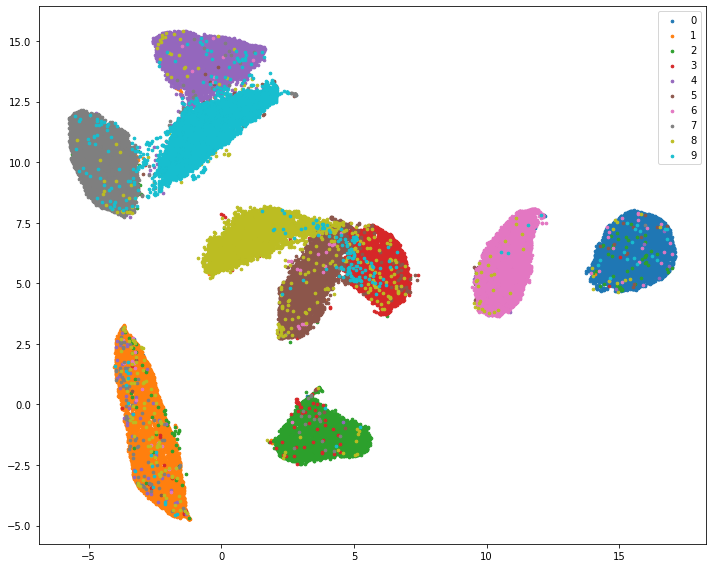

In [66]:
model = umap.UMAP(n_components=2, random_state=42)
model.fit(X)
projection = model.transform(X)

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
for i in range(10):
    ax.scatter(projection[y == str(i), 0], projection[y == str(i), 1], s=7, label=str(i))
plt.legend()
plt.tight_layout()

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿Qué puedes interpretar de la proyección? ¿Las clases han quedado visiblemente separadas? ¿Por qué?
</div>

### RESPUESTA:

**_Las clases para cada número son visibles o están mejor definidas que en las otras técnicas aplicadas sobre el dataset. UMAP es un método de reducción de dimensionalidad no lineal, que es muy efectivo para visualizar clusters o grupos de puntos de datos y sus proximidades. Este dataset presenta las características perfectas para aplicar esta técnica, ya que hay números que presentan grupos de puntos similares entre diferentes clases, que en este caso son las que se encuentran próximas, como lo son la clase 8 con 3 y, 4 con 9._**

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> al igual que anteriormente con PCA, calcula el máximo y mínimo para cada una de las dos dimensiones e invierte la transformación con el modelo aprendido por UMAP para cada uno de los 100 puntos y visualizar su imagen asociada en una matriz de 10 x 10 imágenes (tratando de preservar su posición en el espacio proyectado).
    
<strong>Consejo</strong>: la inversión de la transformación en UMAP es más costosa computacionalmente que con PCA, por lo que recomiendo que sólo la invoques una vez con las 100 muestras en lugar de hacer 100 llamadas (una por cada muestra). Esto reduce drácticamente el tiempo de ejecución.
</div>

In [69]:
# Dimensiones de los componentes obtenidos con UMAP
X_umap1 = projection[:, 0]
X_umap2 = projection[:, 1]

# Mínimo y máximo del UMAP1
Xumap1_max = X_umap1.max()
Xumap1_min = X_umap1.min()

print("Min-Max UMAP1: [{}, {}]".format(Xumap1_min, Xumap1_max))

# Mínimo y máximo del UMAP2
Xumap2_max = X_umap2.max()
Xumap2_min = X_umap2.min()

print("Min-Max UMAP2: [{}, {}]".format(Xumap2_min, Xumap2_max))
print("")

# Secuencias UMAP1 y UMAP2
UMAP1_values = np.linspace(Xumap1_min, Xumap1_max, 10)
UMAP2_values = np.linspace(Xumap2_min, Xumap2_max, 10)

print("Secuencia UMAP1: {}".format(UMAP1_values))
print("Secuencia UMAP2: {}".format(UMAP2_values))

Min-Max UMAP1: [-5.7482123374938965, 17.112035751342773]
Min-Max UMAP2: [-4.745725154876709, 15.420574188232422]

Secuencia UMAP1: [-5.74821234 -3.20818477 -0.66815721  1.87187036  4.41189792  6.95192549
  9.49195306 12.03198062 14.57200819 17.11203575]
Secuencia UMAP2: [-4.74572515 -2.50502523 -0.2643253   1.97637463  4.21707455  6.45777448
  8.69847441 10.93917433 13.17987426 15.42057419]


In [70]:
# Obtener las combinaciones
combinaciones_UMAP = np.array([
    [x, y]
    for x in UMAP1_values
    for y in UMAP2_values
])

# Aplicando la inversa de UMAP
inv_transformed_points_UMAP = model.inverse_transform(combinaciones_UMAP)

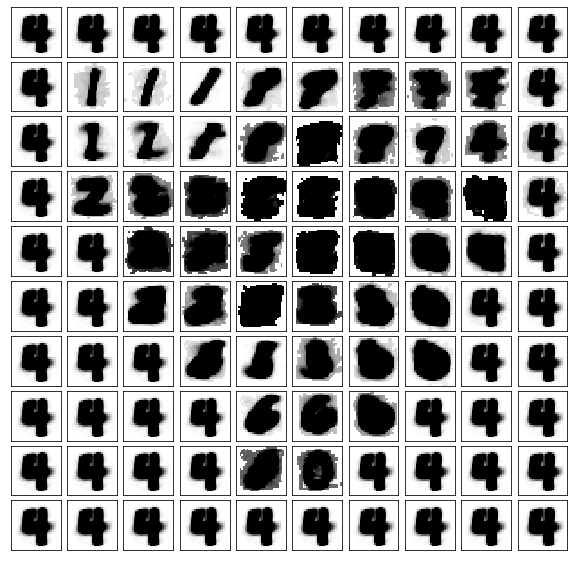

In [71]:
# Trazar la gráfica correspondiente
plot_digits(inv_transformed_points_UMAP)

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿Qué puedes interpretar de las imágenes reconstruidas / interpoladas? ¿Genera números o transiciones entre números visualmente creíbles? ¿Por qué?
</div>

### RESPUESTA:

**Se obtiene un mejor resultado que al aplicar la inversa de PCA. Los números 4 son muy creíbles, es decir que el cluster de los digitos 4 parece bastante bien definido. En menor definición tenemos los clusters de los digitos 1, 2 y 6. Esto se debe a lo que ya se mencionó más arriba, donde UMAP es un método de reducción no lineal, aplicable a casos de uso donde se necesita visualizar clusters o grupos de puntos de datos y sus proximidades.**

<a id="ej3"></a>

## 3. Aplicación: identificación de puntos de interés turísticos (3 puntos)

En este ejercicio se busca automatizar la localización de lugares turísticos a través de los metadatos de las fotografías de flickr.

Para ello se provee junto a la PEC el dataset: ``barcelona.csv``. Ya que se pide encontrar los puntos de mayor interés turístico de esta ciudad.

**Opcional: si quieres hacerlo para otra región**

Pero si quieres hacerlo para otra parte del mundo, puedes descargarte el dataset completo [aquí](https://drive.google.com/file/d/0B-mRR4rjwHPONVFfX2VmTmxZcHM/view?usp=sharing) y descomprime para extraer el *CSV*.

Para seleccionar las coordenadas de la zona de interés puedes usar la opción *Export* manual de [OpenStreetMaps](https://www.openstreetmap.org/).

Por último, para filtrar los datos que se corresponden a la zona deseada puedes usar el programa *AWK* mediante la siguiente línea:

``awk -F"," 'NR == 1 {print $5","$6} (NR > 1 && $5 > 41.3560 && $5 < 41.4267 && $6 > 2.1300 && $6 < 2.2319) {print $5","$6}' photo_metadata.csv``

``$5`` hace referencia a la latitud, y ``$6`` a la longitud. Sustituye los valores mínimo y máximo para obtener los datos de localización referentes a tu área de interés.

In [75]:
geo_df = pd.read_csv('barcelona.csv', header=0)
geo_df.sample(5)

latitude  longitude
16363  41.403426   2.174069
2643   41.373491   2.177653
16305  41.405390   2.163920
5244   41.405688   2.134437
16144  41.375150   2.148942

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> siempre que tratamos un problema real, es necesario entender los datos a tratar. Visualiza las localizaciones de las fotografías mediante un scatter plot. Prueba distintos parámetros de tamaño (<i>size</i>) <i>s</i>, y opacidad <i>alpha</i> hasta conseguir un resultado fácil de interpretar. 
</div>

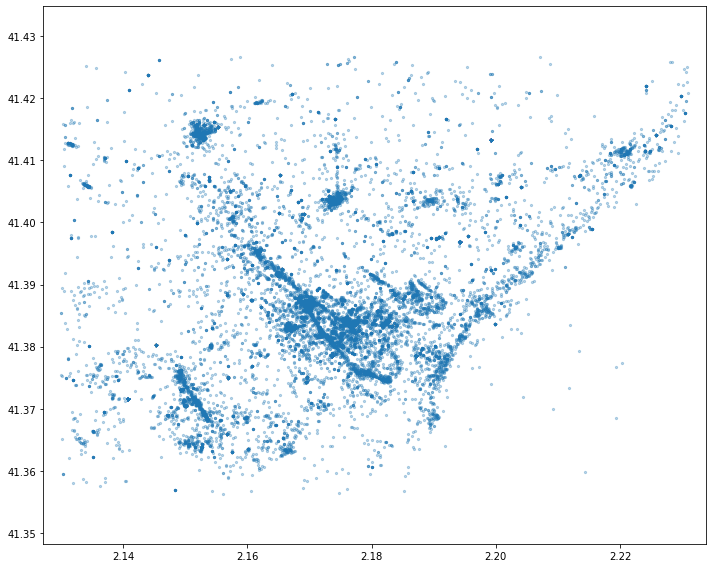

In [76]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.scatter(geo_df['longitude'], geo_df['latitude'], s=5, alpha=.3)
ax.axis('equal')
plt.tight_layout()

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> tras haber probado los algoritmos de agrupamiento en el ejercicio 1. ¿Qué algoritmo crees que sería más adecuado tras visualizar los datos? ¿Por qué?
</div>

### RESPUESTA: 

**Al tratarse de datos geográficos es mejor un algoritmo basado en densidad dado que hay clusters con formas diversas, dependientes de una matriz de distancias, por lo que sería más oportuno usar DBScan, ya que de igual manera vemos que la imagen deja notar que existe ruido de fondo (puntos que no pertenecen precisamente a lugares turísticos).**

**Además según la definición de [DBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html) este método encuentra muestras centrales de alta densidad y expande los clusters a partir de ellos.**

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> para prototipar el modelado primero se recomienda elegir un subconjunto de los datos que sea representativo. Selecciona una muestra del DataFrame original y visualiza como en el punto anterior para comprobar su similitud. 
</div>

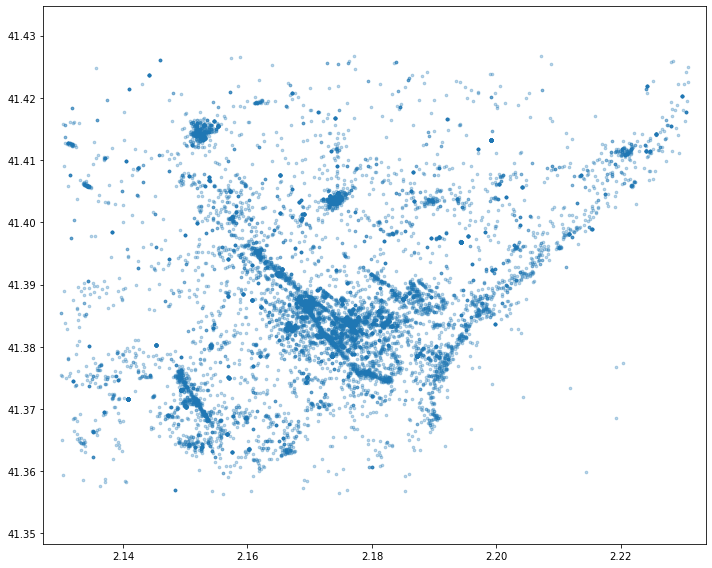

In [78]:
# Muestra del dataframe original
geo_df_sample = geo_df.sample(frac=.75)

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.scatter(geo_df_sample['longitude'], geo_df_sample['latitude'], s=7, alpha=.3)
ax.axis('equal')
plt.tight_layout()

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> ajusta el algoritmo de clustering elegido para encontrar los distintos grupos sobre el conjunto reducido, y visualiza el resultado coloreando cada punto en base al grupo al que pertenece. Como pista, alrededor de 20 clusters es un número razonable, y es posible darles un color distinto a cada uno con el <i>colormap: tab20</i>.
</div>

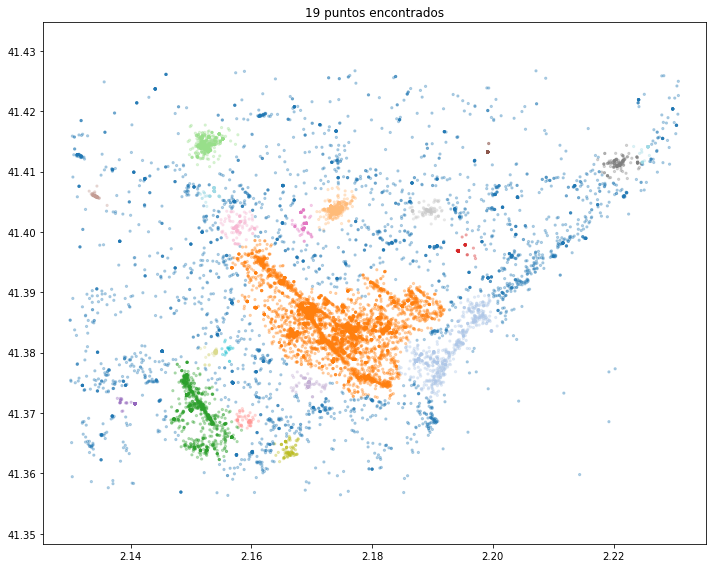

In [86]:
X = geo_df_sample.values
model = cluster.DBSCAN(eps=0.0018, min_samples=55, n_jobs=-1)
points = model.fit(X)

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.scatter(X[:,1], X[:,0], s=5, c=points.labels_, alpha=.3, cmap='tab20')
ax.set_title('{} puntos encontrados'.format(points.labels_.max()))
ax.axis('equal')
plt.tight_layout()

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> si has usado un método de <i>clustering</i> que permite la detección de <i>outliers</i>. Representa sólo los puntos que no ha considerado <i>outliers</i>, es decir, los que pertenecen a algún <i>cluster</i>.
</div>

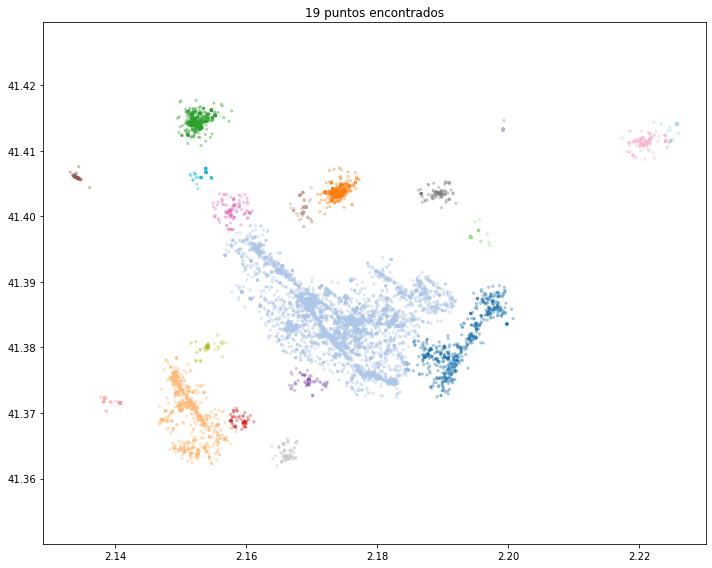

In [87]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.set_title('{} puntos encontrados'.format(points.labels_.max()))
ax.scatter(X[:,1][points.labels_ >= 0], X[:,0][points.labels_ >= 0], s=5, c=points.labels_[points.labels_ >= 0], alpha=.3, cmap='tab20')
ax.axis('equal')
plt.tight_layout()

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> interpreta cual es el lugar que representa cada <i>cluster</i> (si encuentras una asociación lógica).
</div>

### RESPUESTA: 

**Aunque no conozco muy bien Barcelona, puedo por referencias y usando OpenStreetMap ver que hay puntos (clusters) que se corresponden con lugares turísticos, como la Sagrada Familia, el castillo de Montjuic, la Playa y en el punto más alejado el Parque del Carmelo**

<div class="alert alert-block alert-info">
<strong>OPCIONAL Implementación:</strong> representa los puntos sin ruido sobre un mapa utilizando la librería <a href="https://pypi.org/project/smopy/">Smopy</a>. Para facilitar la interpretación, puedes representar cada cluster como el punto medio de todos los puntos que lo conforman.
</div>

Lowered zoom level to keep map size reasonable. (z = 13)


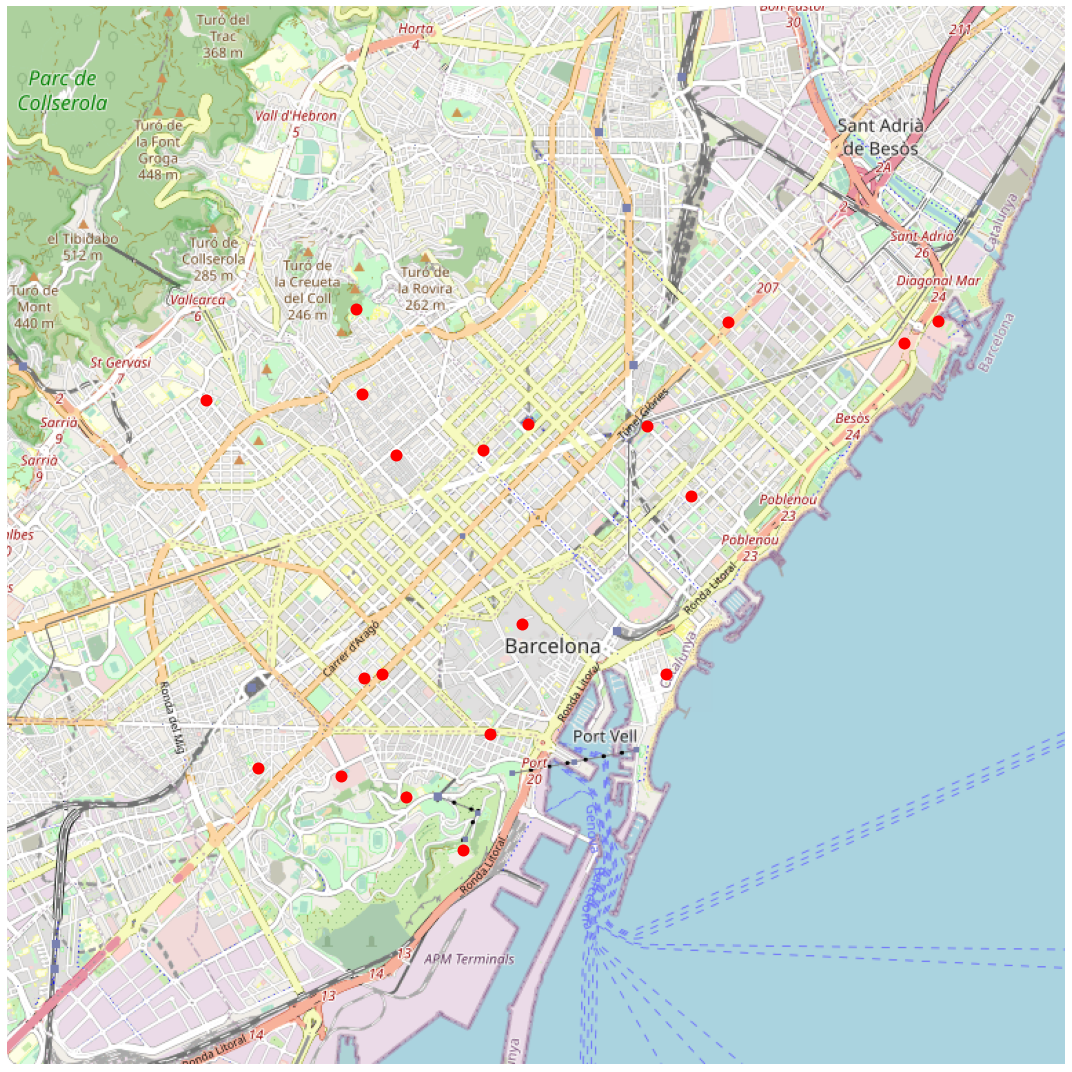

In [89]:
import smopy

map = smopy.Map((41.3560, 2.1300, 41.4267, 2.2319), z=15)
ax = map.show_mpl(figsize=(20, 15))

for i in range(points.labels_.max() + 1):
    x, y = map.to_pixels(X[:,0][points.labels_ == i].mean(), X[:,1][points.labels_ == i].mean())
    ax.plot(x, y, 'or', ms=10, mew=2);